![Project Logo](Project_Logo.pdf)

# Build 0.21h (19 Oct 2020)

### Requires Integrator Version No Eariler than *21 Oct 2020*
### Requires PyUL Helper Version 1

### This is a Public Release
* Y. Wang: [yourong.f.wang@auckland.ac.nz]

* J. Zagorac
* R. Easther


## PyUltraLight 
### Now with N-Body Evalutation and Padded Potentials (H-E-B Scheme) and 2nd-Order Error Management

### Known Limitations
Grid-based ULDM and Continuous Matter Particle, are they really compatible?

### Note on Exploration
Potential padding and NBody are inplemented separately in this version.

### New and Noteworthy Features
- The BH feels a locally averaged ULDM field with customizable averaging method.?
  - The integrator is currently without an explicit check for **Energy Conservation**
- Field appropriately scaled for dynamics.
- Pre-Computed 2-Body Problem Example Scenarios (Parabola and Circular)
- Improved Movie Plotter Performance (Summary Animation, Time Series Graph, or Individual Panels)
- New 3d Volumetric Visualization (needs plotly)
- Automatic Generation of Output Digest to File




In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Loading Required Packages

In [4]:
import PyUltraLight_NBody_6 as PyUL
print('PyUltralight: Integrator Date', PyUL.D_version)

import PyUL_Helper as PyULH

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec
import matplotlib.animation
import math
import pyfftw
import os
import sys
import multiprocessing
import numpy
import numba
import h5py
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.display import clear_output, display

PyUltralight: Integrator Date 2020 10 29, NBody with Integration Mode Switch


# Disk Space Management:

In [3]:
save_path = 'FW_NBody_X'  # Set output directory

PyULH.DSManagement(save_path)

FW_NBody_X : The current size of the folder is 7915.225 Mib
FW_NBody_X : Do You Wish to Delete All Files Currently Stored In This Folder? [Y] 

Y
Folder Cleaned! 

FW_NBody_X : Save Folder Created.


# Set Axion Mass (SI)

In [32]:
axion_mass = 1e-22 *1.783e-36 #kg

In [33]:
print(PyUL.length_unit)

1.1838158462059387e+21


# ULDM Simulation Parameters

In [34]:
resolN = int(6) # 6 -> 64, 7 -> 128, 8 -> 256, 9 -> 512, 
                #10 -> Explosion, 11 -> Just Build CDM Detectors , 12 -> Limit of Human Technology
resol= int(2**resolN)# It is recommended to check the upper bound on soliton mass for a given box size and resolution

# resol = 96 # Uncomment to Override


# Multithreading
num_threads = multiprocessing.cpu_count()
print("PyUL NBody: Available CPU threads for this run: ",num_threads)

# Set units for soliton parameters
s_mass_unit = ''     #Accepted units: 'kg', 'solar_masses', 'M_solar_masses', and '' for dimensionless units
s_position_unit = '' #Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units
s_velocity_unit = '' #Accepted units: 'm/s', 'km/s', 'km/h', and '' for dimensionless units

# Rules ditto.
m_mass_unit = ''
m_position_unit = ''
m_velocity_unit = ''

# Set box size and resolution
length = 12 # 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
length_units = ''  # Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units.


print("PyUL NBody: Simulation Grid Size:", resol, 'cubed.')

LengthFS = PyUL.convert(length, length_units, 'l')

GridLenFS = LengthFS/(resol)

GridLenPC = PyUL.convert_back(GridLenFS,'pc','l')

print("PyUL NBody: The grid resolution subdivision is %.6f in specified units. This is %.6f code units." % ( length/resol, GridLenFS))

duration = 5 #1 code unit is ~70 Gyr (independent of axion mass assumption)
duration_units = ''  # Accepted units: 's', 'yr', 'kyr', 'Myr', and '' for dimensionless units
start_time = 0. # Should be given in the same units as duration. 
step_factor = 1 # Change this to a larger number if velocities are sufficiently low that constraint on timestep can be relaxed. 

#Formats to save
hdf5 = False
npz = False
npy = True


save_number = 100 # Choose number of 'frames' to save. Note that, depending on resolution, this could require significant disk space.


#Data to save
#0
save_rho = True # Saves density data for entire 3D simulation grid
#1
save_psi = False # Saves full complex field data for entire 3D simulation grid
#2
save_plane = True # Saves density data for plane z = 0
#3
save_energies = True # Saves integrated gravitational, kinetic and total energies as lists
#4
save_line = False # Saves density data for line y = 0, z = 0. Useful for examining intereference patterns. 

## FW
#5
save_testmass = True # Saves trajectory and 3-velocity of a test mass thrown into the system.   
#6
save_phi = False
#7
save_phi_plane = True
#8
save_gradients = True


save_options = [save_rho,save_psi,save_plane,save_energies,save_line,save_testmass,save_phi,save_phi_plane,save_gradients]

SaveSizeEstimate = PyULH.SSEst(save_options,save_number,resol)

print('PyUL NBody: Estimated Save Size (GiB): %.02f' % SaveSizeEstimate )

# Data_Loader For Later


PyUL NBody: Available CPU threads for this run:  16
PyUL NBody: Simulation Grid Size: 64 cubed.
PyUL NBody: The grid resolution subdivision is 0.187500 in specified units. This is 0.187500 code units.
PyUL NBody: Saving Mass Density Data (3D)
PyUL NBody: Saving Mass Density Data (2D)
PyUL NBody: Saving Gravitational Field Data (2D)
PyUL NBody: Saving NBody Gradient Data
PyUL NBody: Saving NBody Position Data
PyUL NBody: Estimated Save Size (GiB): 0.20


# Gravitational Field Smoothing
Instead of coding in the idealistic $\frac{m}{r}$ potential, we approximate it with $\frac{am}{ar+e^{-ar}}$. 

The modified potential is a useful approximation of a point mass in a distance, and puts an exponential cap on the infinite potential well, which reduces the impact of numerical artefacts.


The smoothing factor, $a$, is also defined here.


The differences between the two potentials are characterised in the following box.

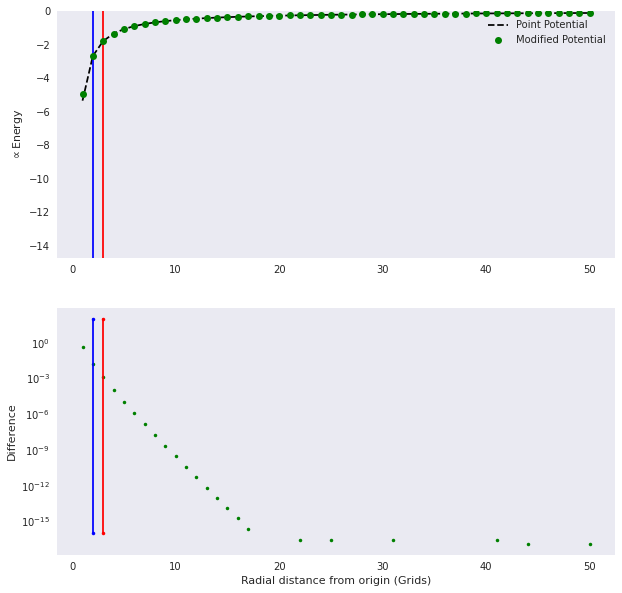

Generating Field Smoothing Report:
  The simulation runs on a 64^3 grid with total side length 12.0
  The simulation grid size is 0.1875 Code Units,
  

==========Grid Counts of Important Features=========

  Radius outside which the fields are practically indistinguishable (Grids): 3
  Modified Potential HWHM (Grids): 2


In [35]:
a = (2-0.15859433956303937)/length*resol

PyULH.SmoothingReport(a,resol,LengthFS)

# Load Example Scenarios:

Just run the following blocks, and "False" scenarios will automatically skip.

Both Parabola and Circular Orbit scenarios come with a great level of customizability, explained below. You can specify the initial positions, masses, and degree of ULDM participation in the dynamics.

If you want to specify your own settings entirely, please set both to False.




## - Parabola 

Describes two masses (soliton or BH or hybrid) with equal mass approaching each other on the $x-y$ plane.

You can specify the $(x_0,y_0)$ value, as well as their masses.

The rest of the initial conditions will then be automatically computed.


## - Circular Orbit 

Describes two masses (soliton or BH or hybrid) with arbitrary masses orbiting each other on the $x-y$ plane.

You can specify the initial separation, as well as their individual masses.

The rest of the initial conditions will then be automatically computed.

## - Tangyuan

This playful new addition has 3 solitons on -x, +y, and -y, and one mass at +x, all equal distance from each other and travels in the same circular orbit around their common centre of mass.
 
## - Collision

Specify your own impact parameter and center of mass location, and the program will try to make sure that the centre of mass stays at rest.

In [59]:
############ PRE-DEFINED MODELS. YOU WILL BE PROMPTED TO SPECIFY THE CUSTOMIZABLE PARAMETERS FOR EACH

Parabola = False
Circular = False
Tangyuan = False
Collision = True

Settings = [Parabola,Circular,Tangyuan,Collision]

############ CREATE YOUR OWN INITIAL CONDITIONS HERE 

#Particle parameters are mass, position, and velocity
#Soliton parameters are mass, position, velocity, and phase (radians)

m1 = 0
mS = 2

BH1 = [m1,[3,0,0],[0,np.sqrt(mS/3),0]]


BHL1 = [8.0, [-0.08333333333333333, -0.5555555555555556, 0], [0, 0.1111111111111111, 0]]
BHL2 = [1.0, [0.6666666666666666, 4.444444444444445, 0], [0, -0.8888888888888888, 0]]

CustomParticles = []

soliton1 = [mS, [0,0,0], [5,5,0], 0]

CustomSolitons = [soliton1]  

############ LOADS DEMO SCENES INTO SYSTEM

particles, solitons = PyULH.Init(Settings,CustomParticles,CustomSolitons,resol,LengthFS)


########### MODIFIER PARAMETERS

# Removes Solitons in the IV and replaces them with a uniform wavefunction 
# with given probability amplitude (code unit).

Uniform = False
Density = 0.01

central_mass = 0 # Not Implemented Anymore. Keep for code compatibility.

Avg = True # Whether we average the black hole local field evaluation.
AvgDist = 1.42
CentreWeight = 1 # The relative weight of central point to the antennae.

NCV, NCW = PyULH.PInit(Avg,AvgDist,CentreWeight)  

if not Uniform:
    print('The List of Soliton Conditions is:')
    print(solitons)
    
print('The List of BH Conditions is:')  
print(particles)



The simulation box edge length is 12.000, at a resolution of 64 

Loading Collision / Scattering Demo
(Approx) Impact Parameter? 

b = 0
Initial Relative Speed (along axial-direction)? 

vRel0 = 0
Initial Separation? 

d = 1
Mass of Particle 

m = 3
Mass of Soliton

m2 = 6
The List of Soliton Conditions is:
[[6.0, [-0.0, -0.3333333333333333, 0], [0, 0.0, 0], 0]]
The List of BH Conditions is:
[[3.0, [0.0, 0.6666666666666666, 0], [0, -0.0, 0]]]


# Compiling Initial Conditions

This creates a timestamped folder using the current settings, and the integrator stores all requested files in it too.

In [60]:
run_folder = PyULH.GenerateConfig(central_mass, length, length_units, resol, duration, duration_units, step_factor, save_number, save_options, save_path, npz, npy, hdf5, s_mass_unit, s_position_unit, s_velocity_unit, solitons,start_time, m_mass_unit, m_position_unit, m_velocity_unit, particles, Uniform,Density,a, NCV,NCW)
loc = './' + save_path + '/' + run_folder
print('Compiled Config in Folder', run_folder)

Method = 1 
# 1: Real Space Linear Interpolation. 2: Fourier Sum

Compiled Config in Folder 2020.10.30_12_06_44_64


In [61]:
# Uncomment for Custom Configs
# run_folder = 'ReX2'

# Execution and Data Loading:

In [62]:
try:
    PyUL.evolve(save_path,run_folder,Method) 
    
    TimeStamp = PyULH.Load_Latest(save_path)
    EndNum, data, TMdata, phidata, graddata = PyULH.Load_Data(save_path,TimeStamp, save_options,save_number)

    
except KeyboardInterrupt:
    print("\n Run Interrupted! The ability to resume simulations is under development.")
    TimeStamp = PyULH.Load_Latest(save_path)
    EndNum, data, TMdata, phidata, graddata = PyULH.Load_Data(save_path,TimeStamp, save_options,save_number)

PyUL_NBody: Loaded Configuration File: ./FW_NBody_X/2020.10.30_12_06_44_64
PyUL_NBody: Using Real-Space Linear Interpolation Between Grids
PyUL_NBody: This run contains 1 ULDM solitons and 1 point Mass partcles. And each soliton step has the particles advanced by 5 step(s) 

PyUL_NBody: The Smoothing Factor is 9.820830188997123 

PyUL_NBody: The ``Point Mass'' Gravitational HWHM is 0.1875 

PyUL_NBody: Simulation Started at 30/10/2020, 12:06:45
PyUL_NBody: Computing Green Functions for Simulation Box 

PyUL_NBody: Initialized Particle # 0 

PyUL_NBody: The Initial TM State Vector Is
 [[ 0.          0.66666667  0.          0.         -0.          0.        ]]
PyUL_NBody: The total number of ULDM simulation steps is 500


[龘龘龘龘龘龘龘龘龘龘龘龘龘龘龘龘龘龘龘龘] 100% Expected Finish Time: 30/10/2020, 12:08:43 (Prev. Step: 0.22s)
Expected Finish Time: 30/10/2020, 12:08:43 (Prev. Step: 0.26s)

PyUL_NBody: Run Complete. Time Elapsed (d:h:m:s): 0:0:1:55
PyUL NBody: Loading Folder 2020.10.30_12_06_44_64
PyUL N

In [56]:
# Emergency Reloading. For Use only after a Kernel Crash
TimeStamp = PyULH.Load_Latest(save_path)

loc = './' + save_path + '/' + TimeStamp
central_mass, length, length_units, resol, duration, duration_units, step_factor, save_number, save_options, save_path, npz, npy, hdf5, s_mass_unit, s_position_unit, s_velocity_unit, solitons,start_time, m_mass_unit, m_position_unit, m_velocity_unit, particles, Uniform,Density,a, NCV,NCW = PyUL.LoadConfig(loc)

EndNum, data, TMdata, phidata, graddata = PyULH.Load_Data(save_path,TimeStamp, save_options,save_number)

PyUL NBody: Loading Folder 2020.10.29_23_58_39_64
PyUL NBody: Loaded Planar Mass Density Data 

PyUL NBody: Loaded Test Mass State Data 

PyUL NBody: Loaded Planar Gravitational Field Data 

PyUL NBody: Loaded Test Mass Gradient Data 

PyUL NBody: Loaded 101 Data Entries


# 2D Trajectory Plot

<Figure size 576x396 with 0 Axes>

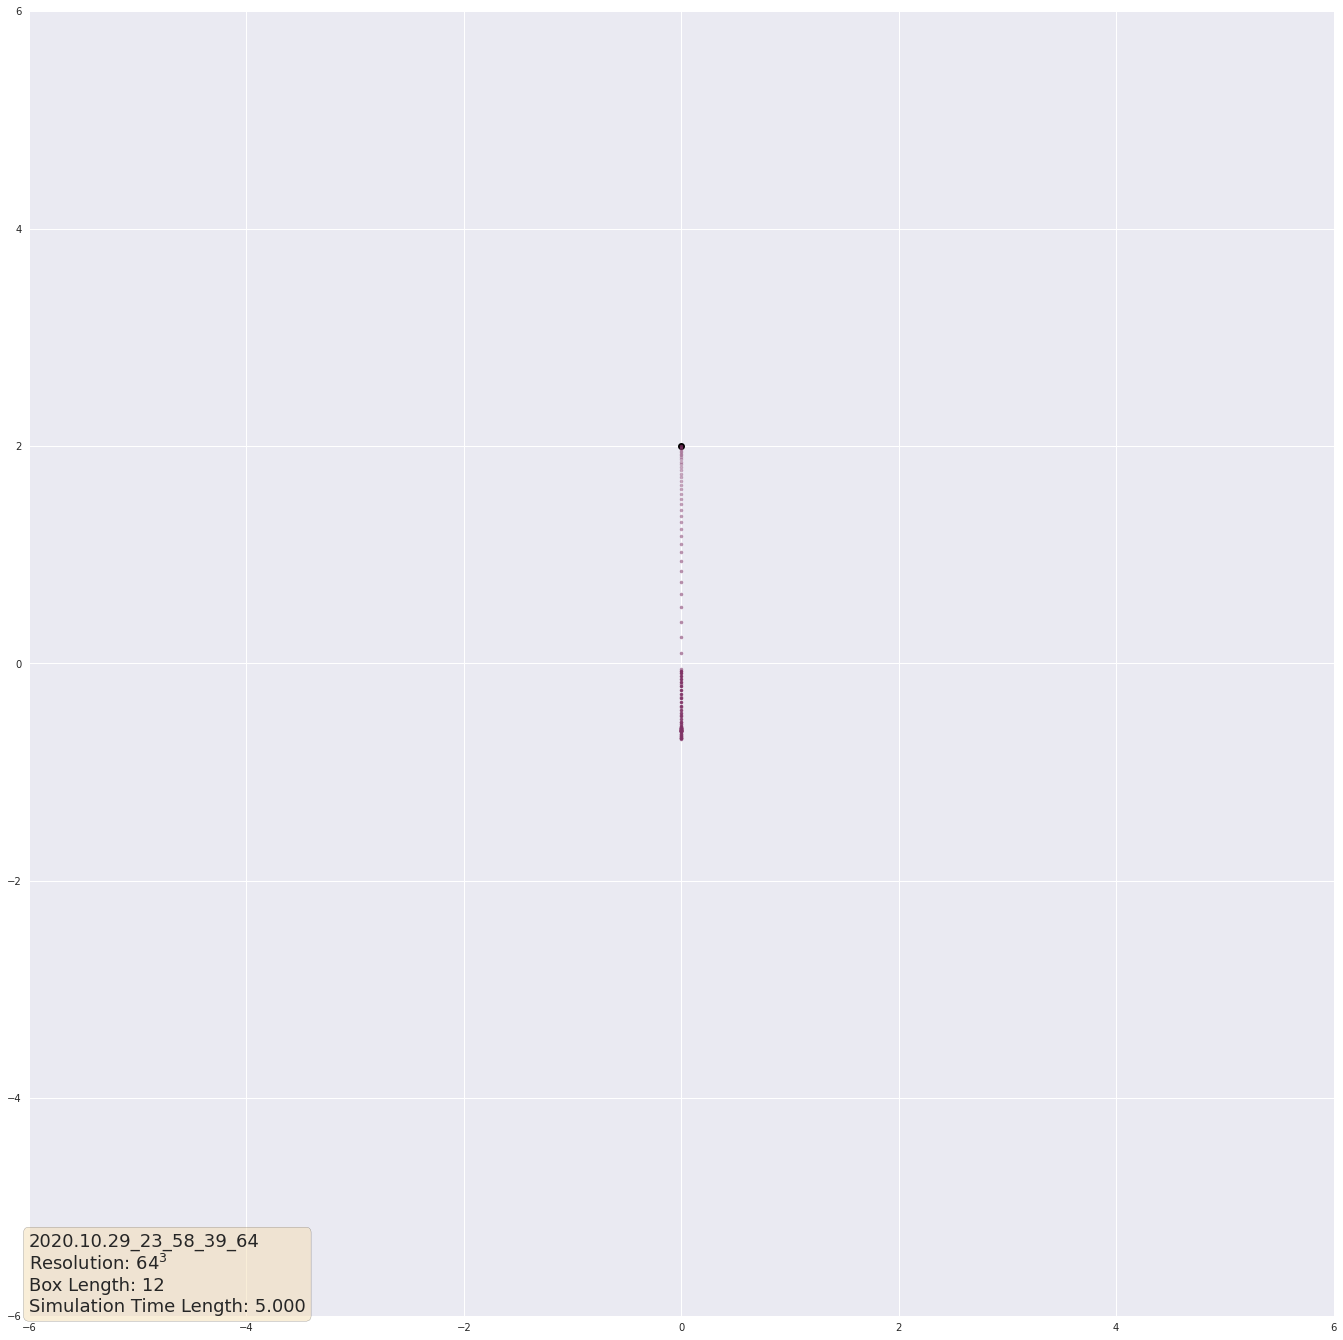

2020.10.29_23_58_39_64


In [57]:
try:
    TSD = TimeStamp
except NameError:
    TimeStamp = 'Debug'

plt.clf()

fig = plt.figure(figsize=(24, 24))
# debug
import numexpr as ne
import matplotlib as mpl

Zoom2D = 1

Boundary = length/(2*Zoom2D)

ax = fig.add_subplot(111)
mpl.style.use('seaborn')
'''
if Parabola:
    yParaBola = np.linspace(-length/(2),length/(2),resol)
    xParaBola = ne.evaluate("yParaBola**2/(4*c0)-c0")

    plt.plot(xParaBola,yParaBola)

    plt.plot(-xParaBola,yParaBola)
    

if Circular:
    
    tCirc = np.linspace(0,2*np.pi,200)

    plt.plot(x1*np.cos(tCirc),x1*np.sin(tCirc),'-',color = (1,0.5,0,0.1))
    plt.plot(x2*np.cos(tCirc),x2*np.sin(tCirc),'-',color = (1,0,0.5,0.1))

'''

plt.xlim([-Boundary,Boundary])
plt.ylim([-Boundary,Boundary])


ax.set_aspect('equal', adjustable='box')

for i in range(EndNum):
    
    
    TMStateLoc = TMdata[i]
    
    if i == 0:
        for particleID in range(len(particles)):
        
            ColorID = particleID/len(particles) # 0, 0.5
        
            TMx = TMStateLoc[int(6*particleID)]
            TMy = TMStateLoc[int(6*particleID+1)]
            plt.plot([TMx],[TMy],'ko')
        
    
    Alpha = 0.3+7*i/(10*EndNum)
    
    for particleID in range(len(particles)):
        
        ColorID = 0.2 # 0, 0.5
        
        TMx = TMStateLoc[int(6*particleID)]
        TMy = TMStateLoc[int(6*particleID+1)]
        plt.plot([TMx],[TMy],'.',color=(0.5,1*ColorID,0.6-ColorID,Alpha))
        
ax.grid(True)

textstr = '\n'.join((
    TimeStamp,
    r'Resolution: $%.0f^3$' % (resol, ),
    r'Box Length: %.0f' % (length, ),
    r'Simulation Time Length: %.3f' % (duration, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0, 0, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='bottom', bbox=props)

TrajName = '{}{}{}{}{}'.format("./",save_path,"/_",TimeStamp,'.jpg')
plt.savefig(TrajName, format='jpg', dpi=72)


plt.show()

print(TimeStamp)

# Energy Processing and Plotting

[3.0]
1


<Figure size 576x396 with 0 Axes>

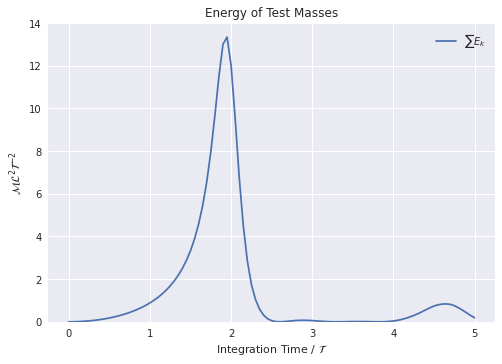

FW_NBody_X/2020.10.29_23_58_39_64


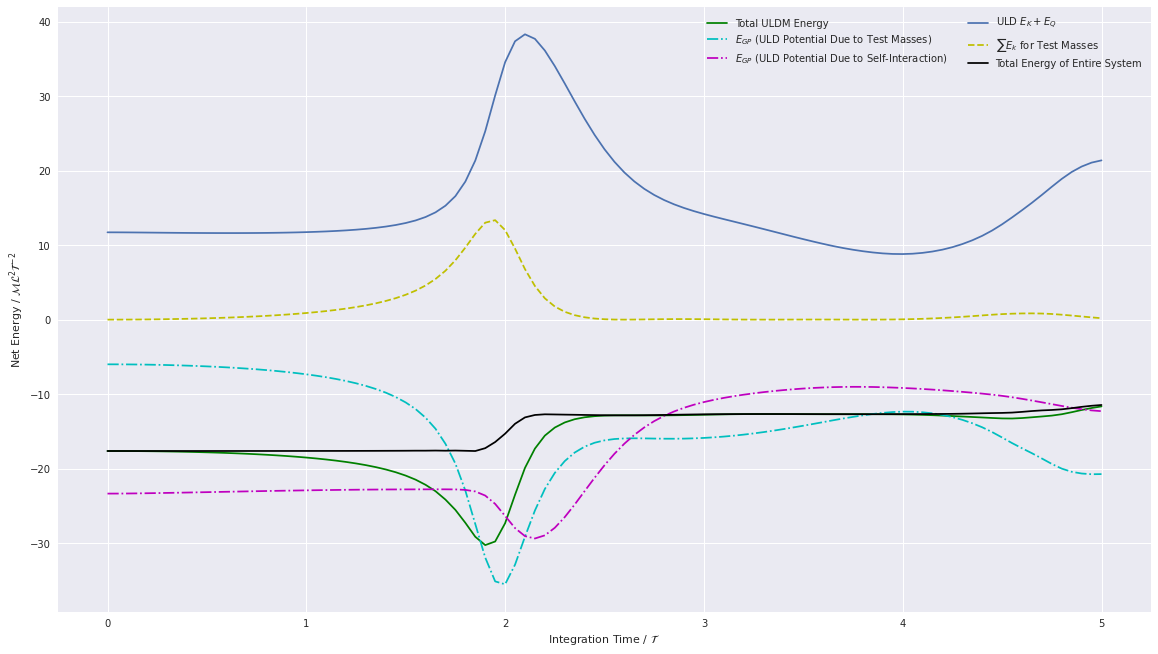

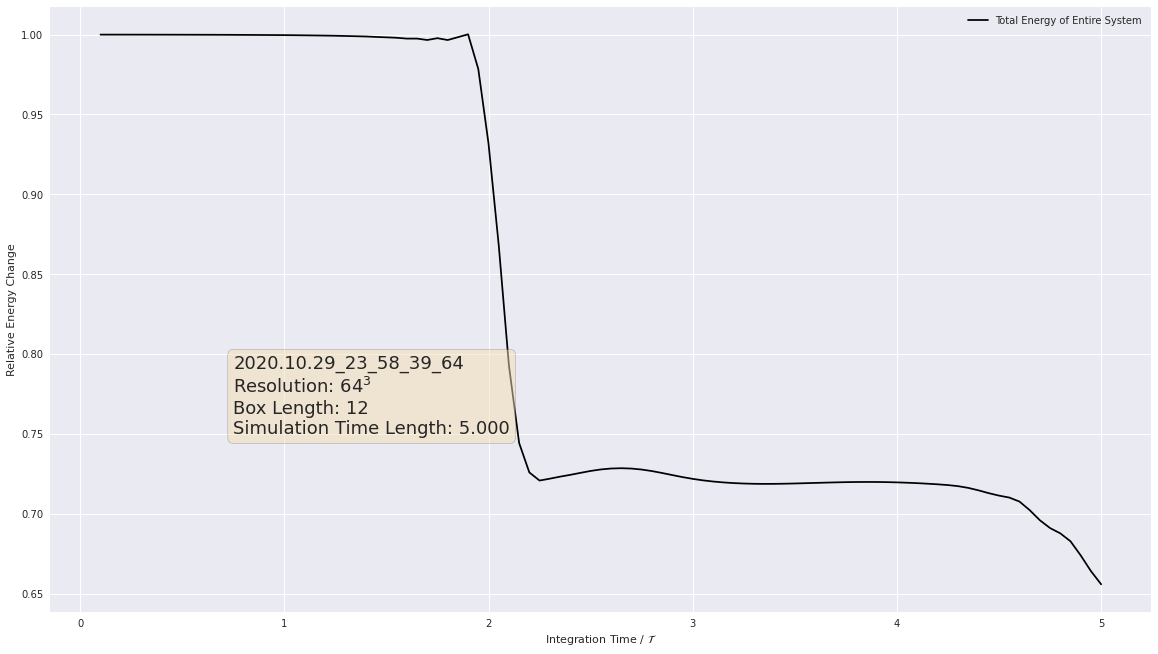

In [58]:
Snap = False

loc = save_path + '/' + TimeStamp

plt.clf()

# Reconstruct List of Masses

ML = []
for i in range(len(particles)):
    particle = particles[i]
    
    mass = particle[0]
    
    ML.append(mass)

    print(ML)

# Translating Snapshots back to Time
timerange = np.linspace(0,duration,save_number+1)


KS = np.zeros(int(EndNum))
PS = np.zeros(int(EndNum))

print(len(particles))
for i in range(int(EndNum)):
    
    Data = TMdata[i]
    
    if len(particles)==2:

        r = Data[0:2] - Data[6:8]

        rN = np.linalg.norm(r)
        
        m1 = ML[0]
        m2 = ML[1]
    
        PS[i] = -1*m1*m2*a/(a*rN+np.exp(-1*a*rN))
   
    for particleID in range(len(particles)):
        Vx = Data[int(6*particleID+3)]
        Vy = Data[int(6*particleID+4)]
        Vz = Data[int(6*particleID+5)]
        
        KS[i] = KS[i] + 1/2*ML[particleID]*(Vx**2+Vy**2+Vz**2) 

Tp = np.linspace(0,EndNum,EndNum)

Tp = Tp/EndNum * duration

plt.figure()
plt.plot(Tp,KS,label = '$\sum E_k$')
plt.ylim(0,)
if len(particles) == 2:
    plt.plot(Tp,PS,label = '$\sum E_p$')
    plt.plot(Tp,PS+KS,'-', label = '$E_k + E_p$')
#plt.plot(Tp,0*Tp,'k--')

plt.title('Energy of Test Masses')
plt.xlabel('Integration Time / $\mathcal{T}$')
plt.ylabel('$\mathcal{M}\mathcal{L}^2\mathcal{T}^{-2}$')

plt.legend()

plt.show()


EnergyName = '{}{}{}{}{}'.format("./",save_path,"/Total_",TimeStamp,'.jpg')


fig = plt.figure(figsize=(16, 9))

print(loc)

egylist = np.load('{}{}'.format(loc, '/egylist.npy'))
egpcmlist = np.load('{}{}'.format(loc, '/egpcmlist.npy'))
egpsilist = np.load('{}{}'.format(loc, '/egpsilist.npy'))
ekandqlist = np.load('{}{}'.format(loc, '/ekandqlist.npy'))
mtotlist = np.load('{}{}'.format(loc, '/masseslist.npy'))

plt.plot(Tp,egylist,'g-',label='Total ULDM Energy')
plt.plot(Tp,egpcmlist,'c-.',label='$E_{GP}$ (ULD Potential Due to Test Masses)')
plt.plot(Tp,egpsilist,'m-.',label='$E_{GP}$ (ULD Potential Due to Self-Interaction)')
plt.plot(Tp,ekandqlist,label='ULD $E_{K}+E_{Q}$')


plt.plot(Tp,KS,'y--',label = '$\sum E_k$ for Test Masses')

if len(particles) == 2:
    plt.plot(Tp,PS,'r--',label = '$\sum E_p$ for Test Masses')
    plt.plot(Tp,PS+KS,'b-', label = 'Total Energy of Test Masses')


plt.plot(Tp,PS+KS+egylist,'k-', label = 'Total Energy of Entire System')

plt.legend(ncol=2)

plt.xlabel('Integration Time / $\mathcal{T}$')
plt.ylabel('Net Energy / $\mathcal{M}\mathcal{L}^2\mathcal{T}^{-2}$')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

plt.savefig(EnergyName, format='jpg', dpi=72)


# plt.xlim([90,100])
plt.show()


# The Energy Change Diagram for Animation

Tpt = np.linspace(2,EndNum+1,EndNum-2,endpoint = False) 

Tpt = Tpt/EndNum * duration

KSD = KS - KS[1]

PSD = PS - PS[1]

egylistD = egylist - egylist[1]

TotalED = PSD+KSD+egylistD


# The Advanced Energy Change Ratio Diagram

fig = plt.figure(figsize=(16, 9))

EnergyDName = '{}{}{}{}{}'.format("./",save_path,"/Delta_",TimeStamp,'.jpg')


TotalER = (KS + PS + egylist) / (KS[1]+PS[1]+egylist[1])

ULDER =  egylist/ egylist[1]

#if len(particles)==2:
#    SystemER = (KS + PS ) / (KS[1]+PS[1])
#    plt.plot(Tpt,SystemER[1:-1],'b-', label = 'Total Energy of Black Holes')

if Snap:
    plt.plot(TotalER[1:-1],'k-', label = 'Total Energy of Entire System')
    plt.xlabel('Sample Number')
    
else:
    plt.plot(Tpt,TotalER[1:-1],'k-', label = 'Total Energy of Entire System')
    plt.xlabel('Integration Time / $\mathcal{T}$')

#plt.plot(Tpt,ULDER[1:-1],'g-', label = 'Total Energy of ULDM within Simulation Grid')

plt.legend()

textstr = '\n'.join((
    TimeStamp,
    r'Resolution: $%.0f^3$' % (resol, ),
    r'Box Length: %.0f' % (length, ),
    r'Simulation Time Length: %.3f' % (duration, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
plt.text(0, 0, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='bottom', bbox=props)

plt.ylabel('Relative Energy Change')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

#plt.ylim([0.95,1.05])
plt.savefig(EnergyDName, format='jpg', dpi=72)

plt.show()




# Summary Animation

PyUL NBody: Loaded Planar Mass Density Data 

PyUL NBody: Loaded Test Mass State Data 

PyUL NBody: Loaded Planar Gravitational Field Data 

PyUL NBody: Loaded Test Mass Gradient Data 

PyUL NBody: Loaded 101 Data Entries
[3.0]
Saving  ./FW_NBody_X/AnimSummary_2020.10.29_23_58_39_64.mp4
Animated 1 seconds out of 3.37 seconds of data.
Animated 2 seconds out of 3.37 seconds of data.
Animated 3 seconds out of 3.37 seconds of data.


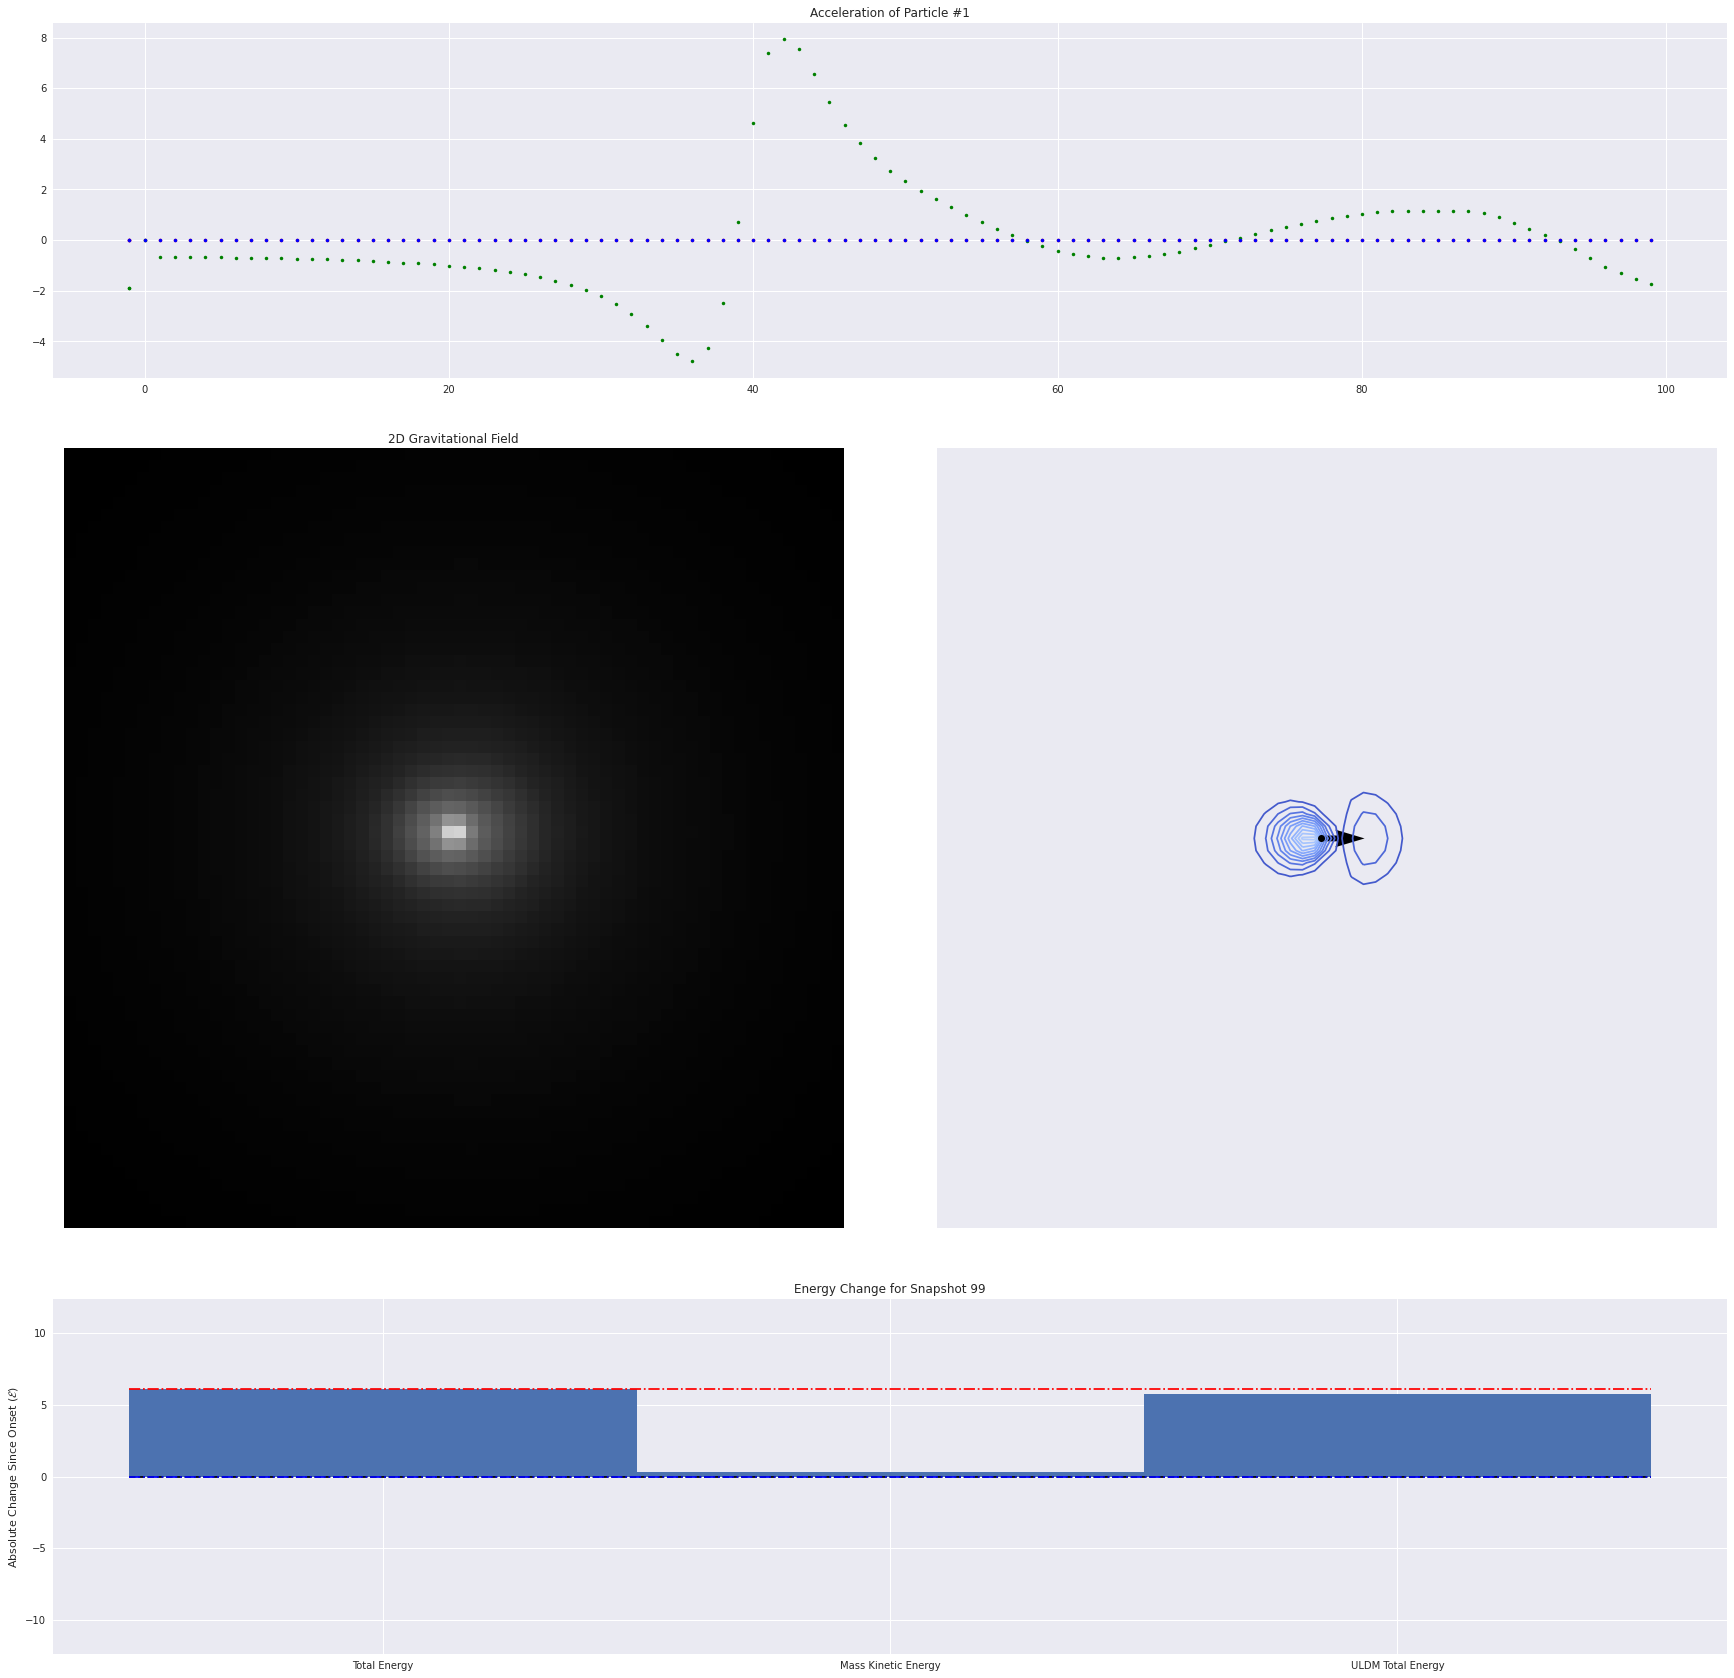

In [44]:
PyULH.AnimSummary(TimeStamp,save_path,30,30,30,False,1,True)

# Additional Individual Plots

## [Animation] 2D Field Gradient Scan Plot

In [ ]:
try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')
    
Skip = 1
AnimLength = int(EndNum/Skip)

AnimName = '{}{}{}{}'.format(save_path,"/AnimCTM_",VTimeStamp,'.mp4')

print("Saving ",AnimName)

plt.ioff()
fig, ax = plt.subplots(figsize=(16, 9), dpi= 240)
ax.set_aspect('equal')

FPS = 30
# Loop


from scipy.interpolate import RegularGridInterpolator as RPI


Grids = 2 # Number of Grids to Cover in Each Direction

gridlength = length

HalfGrid = gridlength/resol/2*Grids

TestResol = 15

if save_rho:
    
    with open('{}{}'.format(save_path, '/latest.txt'), 'r') as timestamp:
        ts = timestamp.read()
        print('PyUL NBody: Loading Folder',ts)

    loc = save_path + '/' + ts

    import time   
    import warnings 
    warnings.filterwarnings("ignore")
    plt.ioff()

    EndNum = 0
    Rhodata = []
    TMdata = []

    for x in np.arange(0,save_number+1,1):
    #for x in np.arange(0,550,1):    

        try:
            Rhodata.append(np.load('{}{}{}{}'.format(loc, '/rho_#', x, '.npy')))
            TMdata.append(np.load('{}{}{}{}'.format(loc, '/TM_#', x, '.npy')))
            EndNum += 1
        except FileNotFoundError:

            TimeStamp = ts
            print("PyUL NBody: Run incomplete or the storage is corrupt!")

            break


rkvec = 2 * np.pi * np.fft.fftfreq(resol, gridlength / float(resol))

krealvec = 2 * np.pi * np.fft.rfftfreq(resol, gridlength / float(resol))

rkxarray, rkyarray, rkzarray = np.meshgrid(
    rkvec, rkvec, krealvec,
    sparse=True, indexing='ij'
)

rkarray2 = ne.evaluate("rkxarray**2+rkyarray**2+rkzarray**2")

gridvec = np.linspace(-gridlength / 2.0, gridlength / 2.0, resol, endpoint=False)

WN = 2*np.pi*np.fft.fftfreq(resol, gridlength/(resol)) # 2pi Pre-multiplied
    
Kx,Ky,Kz = np.meshgrid(WN,WN,WN,sparse=True, indexing='ij',)
    
masslist = [particles[0]]

HWHM = (PyUL.LW(-np.exp(-2))+2)/a # inversely proportional to a.
    
HWHM = np.real(HWHM)

datamax = np.max(data)
datamin = np.min(data)
    
ind = 0

sX = np.zeros([TestResol+1,TestResol+1])
sY = np.zeros([TestResol+1,TestResol+1])
sZ = np.zeros([TestResol+1,TestResol+1])

sXI = np.zeros([TestResol+1,TestResol+1])
sYI = np.zeros([TestResol+1,TestResol+1])

def animatePlot(i):
    
    ax.cla()
    
    ind = i*Skip
    RhoFun = Rhodata[ind]
    
    TMState = TMdata[ind]
    
    phik = np.fft.rfftn(RhoFun)
            
    phik = ne.evaluate("-4*3.141593*(phik)/rkarray2")
    
    phik[0, 0, 0] = 0
            
    # This Converts the RFFTn to FFTn
    FieldFT = PyUL.FieldProcess(phik, gridlength, resol)

    positionOG = np.array([TMState[0],TMState[1],TMState[2]])
    
    position = np.array([TMState[0]-HalfGrid,TMState[1]-HalfGrid,TMState[2]])
    
    LowerBoundX = position[0]
    
    LowerBoundY = position[1]
    
    UpperBoundX = LowerBoundX + HalfGrid*2
    
    UpperBoundY = LowerBoundY + HalfGrid*2

    phisp = np.fft.irfftn(phik)
    
    phiGrad = np.gradient(phisp, gridvec,gridvec,gridvec, edge_order = 2)
    
    phiGrad = phiGrad
    
    phiGradX = phiGrad[0]*-1
    
    phiGradXI = RPI([gridvec,gridvec,gridvec],phiGradX,method = 'linear',bounds_error = False, fill_value = 0)
    
    phiGradY = phiGrad[1]*-1
    
    phiGradYI = RPI([gridvec,gridvec,gridvec],phiGradY,method = 'linear',bounds_error = False, fill_value = 0)
    
    
    PAX = np.linspace(LowerBoundY,UpperBoundY,TestResol+1)
    
    PAY = np.linspace(LowerBoundX,UpperBoundX,TestResol+1)
    
    X,Y = np.meshgrid(PAX,PAY)
    
    print(positionOG)
    
    for sH in range(TestResol+1):
        for sV in range(TestResol+1):
            positionLoc = position + np.array([sH,sV,0])*HalfGrid/TestResol*2
        
            Gradient = -1*PyUL.FieldGradient(gridlength,Kx,Ky,Kz,FieldFT,positionLoc,resol)
            
            sX[sH,sV] = Gradient[0]
            sY[sH,sV] = Gradient[1]
            sZ[sH,sV] = Gradient[2]
            
            sXI[sH,sV] = phiGradXI(positionLoc)
            sYI[sH,sV] = phiGradYI(positionLoc)
    
    
    # Major ticks every 20, minor ticks every 5
    
    major_ticks = gridvec
    minor_ticks = np.arange(0, 101, 5)
    
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    ax.set_title('ULDM Field Gradient (2D) evaluated using Fourier Series')
    
    ax.set_aspect('equal')
    # And a corresponding grid
    ax.grid(which='both')
    
    # Or if you want different settings for the grids:
    ax.grid(which='major', alpha=0.2)
    
    #plt.imshow(sY, norm = None, origin  = 'lower', extent = (LowerBoundX,UpperBoundX,LowerBoundY,UpperBoundY))
    
    plane = data[ind]
    
    plt.imshow(plane,vmin = datamin, vmax = datamax ,norm = None, origin  = 'lower', extent = (-gridlength/2,gridlength/2-gridlength/resol,-gridlength/2,gridlength/2-gridlength/resol),cmap = 'plasma')
    #plt.colorbar()
    
    plt.quiver(X,Y,sY,sX,color = 'white',scale = 20, alpha = 0.28)
    plt.quiver(X,Y,sYI,sXI,color = 'orange', scale = 20, alpha = 0.29)
    
    plt.plot([positionOG[1]],[positionOG[0]],'wo')
    
    ax.set_xlim([LowerBoundY,UpperBoundY])
    ax.set_ylim([LowerBoundX,UpperBoundX])
    
    
    if i%FPS == 0 and i!= 0:
        clear_output()
        print('Animated %.0f seconds out of %.2f seconds of data.' % (i/FPS, EndNum/FPS))
    
    if i == EndNum-1:
        print('Animation Complete')
        
        
interval = 0.15 #in seconds

ani0 = matplotlib.animation.FuncAnimation(fig,animatePlot,AnimLength,interval=interval*1e+3,blit=False)

Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))

ani0.save(AnimName, writer=writer)
    

## [Animation] 2D Mass Density

In [ ]:
Loga = False 

try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')

AnimName = '{}{}{}{}'.format(save_path,"/Anim2D_",VTimeStamp,'.mp4')

print("Saving ",AnimName)

plot_axis = 'z' #axis that is set to zero
plt.ioff()
fig0, ax0 = plt.subplots(figsize=(16, 9), dpi=144)
ax0.set_aspect('equal')


if Loga:
    
    if Uniform:
        data0 = np.log(np.array(data)/Density)
        print("Initial Field is Uniform. Evaluating Change Ratio.")
    
    else:
        data0 = np.log(data)
    planemax = np.max(data0)
    planemin = -25
    
    print("Using Log Plot, the Contour Level Limits Are")
    print(planemax,planemin)
    
else:
    data0 = (data)
    planemax = np.max(data0)
    planemin = np.min(data0)
        
levels = np.linspace(planemin, planemax, int(resol*2))

PlotRange = np.linspace(-length/2, length/2,resol,endpoint = False)

# print(PlotRange)

FPS = 10


def animate0(i):
    ax0.cla()
    ax0.set_aspect('equal')
    ax0.set_xlim([-length/2,length/2])
    ax0.set_ylim([-length/2,length/2])
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([])
    
    ax0.contour(PlotRange,PlotRange,data0[i], levels=levels,cmap = 'coolwarm')
    #ax0.imshow(data[i])

    TMStateLoc = TMdata[i]
    for particleID in range(len(particles)):
        TMx = TMStateLoc[int(6*particleID)]
        TMy = TMStateLoc[int(6*particleID+1)]
        TMz = TMStateLoc[int(6*particleID+2)]
        
        Vx = TMStateLoc[int(6*particleID+3)]
        Vy = TMStateLoc[int(6*particleID+4)]
        Vz = TMStateLoc[int(6*particleID+5)]
        ax0.plot([TMy],[TMx],'ko')
        ax0.quiver([TMy],[TMx],[Vy],[Vx])
        
    fig0.suptitle('{}{}{}'.format('Mass Density - plane ', plot_axis, '=0'), fontsize = 15)
    ax0.text(0.90, 1.1, '{}{}'.format('Snapshot # ', i), horizontalalignment='center', verticalalignment='center', transform=ax0.transAxes)
    
    if i%FPS == 0 and i!= 0:
        print('Animated %.0f seconds out of %.2f seconds of data.' % (i/FPS, EndNum/FPS))
    
    if i == EndNum-1:
        print('Animation Complete')

interval = 0.15 #in seconds
ani0 = matplotlib.animation.FuncAnimation(fig0,animate0,EndNum,interval=interval*1e+3,blit=False)

Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))

# ani0.save(AnimName, writer=writer)



from IPython.display import HTML
animated_plot0 = HTML(ani0.to_jshtml())



fig0.clear()
display(animated_plot0) 

## [Animation] Gravitational Field Slice

In [ ]:
NumSol = len(solitons)
try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')

AnimName = '{}{}{}{}'.format(save_path,"/Anim3D_",VTimeStamp,'.mp4')

print("Saving ",AnimName)

# Initialization
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')

ax.view_init(90, 0)

PlotRange = np.linspace(-length/2, length/2,resol)

zoom = 0.8

FPS = 15 

x3D, y3D = np.meshgrid(PlotRange,PlotRange)

phidataP = np.array(phidata)*-1

planemax = np.max(phidataP)*1.2
planemin = np.min(phidataP)

print(planemin,planemax)

levels = np.linspace(planemin, planemax, 100)

def animate(i):
    fig.clear()
    global FPS
    
    TMStateLoc = TMdata[i]
    ax = fig.gca(projection='3d')

    ax.view_init(0, 45)

    ax.set_zlim3d(planemin, planemax)
    ax.set_ylim3d(-length/(2*zoom), length/(2*zoom))                    
    ax.set_xlim3d(-length/(2*zoom), length/(2*zoom))

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    if NumSol != 0:
        
        #ax.contour(PlotRange,PlotRange,(phidata[i]),zdir='z', offset=0, cmap=cm.coolwarm, levels = levels)
        

        zs = phidataP[i].flatten()
        ax.plot_wireframe(x3D,y3D,phidataP[i],rcount = resol, ccount = resol)
 
    
    for particleID in range(len(particles)):
        TMx = TMStateLoc[int(6*particleID)]
        TMy = TMStateLoc[int(6*particleID+1)]
        TMz = TMStateLoc[int(6*particleID+2)]
        
        Vx = TMStateLoc[int(6*particleID+3)]
        Vy = TMStateLoc[int(6*particleID+4)]
        Vz = TMStateLoc[int(6*particleID+5)]
        ax.plot([TMy],[TMx],[TMz],'ko')
        ax.quiver([TMy],[TMx],[TMz],[Vy],[Vx],[Vz],length=length/(resol*zoom), normalize=False)
    #ax.plot([TMS[i,0]],[TMS[i,1]],[TMS[i,2]],'ro')
    
        ax.text(TMy, TMx, TMz, '{}{}{}'.format(particleID,'Particle Snapshot # ', i))

    
    if i%FPS == 0 and i!= 0:
        print('Animated %.0f seconds out of %.2f seconds of data.' % (i/FPS, EndNum/FPS))
        
    if i == EndNum-1:
        print('Animation Complete')
        
    plt.draw() 

Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))

interval = 0.05 #in seconds


ani = matplotlib.animation.FuncAnimation(fig,animate,EndNum,interval=interval*1e+3,blit=False)

ani.save(AnimName, writer=writer)
 

# Acceleration of Particles

In [ ]:
pID = 0 # 0,1,2,...

plt.clf()
plt.figure(figsize=(16, 9))

graddataP = (graddata)
for i in range(EndNum):
    pID = pID*3
    plt.plot(i,graddataP[i][0],'r.',label = '$x$')
    plt.plot(i,graddataP[i][1],'g.',label = '$y$')
    plt.plot(i,graddataP[i][2],'b.',label = '$z$')

plt.xlabel('Snapshot Number')
plt.ylabel('Particle Acceleration')
plt.legend()
plt.show()

## Rate Estimate of Energy Change

In [ ]:
timerange = np.linspace(0,duration,save_number+1)

TotalED = PSD+KSD+egylistD

EDFit = np.polyfit(timerange,TotalED,1)

print(EDFit)

MaxED = max(TotalED.min(), TotalED.max(), key=abs)

FinalED = TotalED[-1]

print(FinalED, MaxED)

plt.figure(figsize = (16,9))

plt.plot(timerange,TotalED,'k-')

plt.plot(timerange,EDFit[0]*timerange+EDFit[1],'r--')

plt.show()

## [Bonus Interactive]: 3D Field Visualization

Loads all data into RAM. Very slow.

In [ ]:
if save_rho:
    
    with open('{}{}'.format(save_path, '/timestamp.txt'), 'r') as timestamp:
        ts = timestamp.read()
        print('PyUL NBody: Loading Folder',ts)

    loc = save_path + '/' + ts

    import time   
    import warnings 
    warnings.filterwarnings("ignore")
    plt.ioff()

    EndNum = 0
    Rhodata = []
    TMdata = []

    for x in np.arange(0,save_number+1,1):
    #for x in np.arange(0,550,1):    

        try:

            Rhodata.append(np.load('{}{}{}{}'.format(loc, '/rho_#', x, '.npy')))
            TMdata.append(np.load('{}{}{}{}'.format(loc, '/TM_#', x, '.npy')))
            EndNum += 1
        except FileNotFoundError:

            TimeStamp = ts
            print("PyUL NBody: Run incomplete or the storage is corrupt!")

            break

    print("PyUL NBody: Loaded", EndNum, "Data Entries. Which one to plot?")
    
    PlotNum = int(input())

    import plotly.graph_objects as go
    
    import plotly.io as pio
    
    import numpy as np
    
    if Uniform:
        Rhodata = np.log(np.array(Rhodata))
        
    

    HL = length/2
    XP, YP, ZP = np.mgrid[-HL:HL:resol/4*1j, -HL:HL:resol/4*1j, -HL:HL:resol/4*1j]

    print(len(XP))
    values = Rhodata[PlotNum]
    
    values = values.flatten()
    
    shrink = int(resol/4)**3
    
    Values = np.zeros(shrink)
    
    for ii in range(shrink):
        Values[ii] = values[int(ii*4)]

    fig3D = go.Figure(data=go.Volume(
        x=XP.flatten(),
        y=YP.flatten(),
        z=ZP.flatten(),
        value=Values,
        isomin=np.min(Rhodata),
        isomax=np.max(Rhodata),
        opacity=0.02, # needs to be small to see through all surfaces
        surface_count=int(resol/4), # needs to be a large number for good volume rendering
        ))

else:
    raise RuntimeError("You did not save field data!")

In [ ]:
import plotly.io as pio
pio.write_html(fig3D, 'Trial.html')

## [Bonus Interactive]: 3D Density Visualization

In [ ]:
print(phidataP[1])

In [ ]:
import plotly.graph_objects as go
 
import plotly.io as pio
import numpy as np

import pandas as pd

phidataPL = pd.DataFrame(data=phidataP[287], index=None, columns=None)

fig = go.Figure(data=[go.Surface(z=phidataPL.values)])

#fig.update_layout(title='$z=0$', autosize=False,width=500, height=500,margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [ ]:
pio.write_html(fig, 'Soliton512.html')

In [ ]:
print(phidataPL)

In [ ]:
z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')

fig = go.Figure(data=[go.Surface(z=z_data.values)])

fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [ ]:
print(z_data)